In [1]:
import torch, torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [3]:
# Dataset

train_dataset = torchvision.datasets.MNIST(
    root = "data",
    download = True,
    train = True,
    transform = torchvision.transforms.ToTensor()
)

test_dataset = torchvision.datasets.MNIST(
    root = "data",
    download = True,
    train = False,
    transform = torchvision.transforms.ToTensor()
)

4

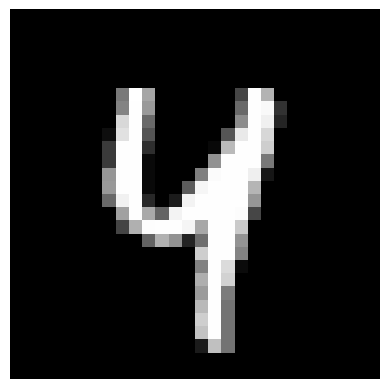

In [5]:
IDX = 42

image, label = test_dataset[42]

plt.imshow(image.squeeze().numpy(), cmap = "gray")
plt.axis(False)

label

In [7]:
# DataLoader

BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = True
)

In [9]:
dataloader_element = next(iter(train_dataloader))

dataloader_element[0].shape

torch.Size([64, 1, 28, 28])

In [11]:
# Neural Network - model pattern

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,10)
)

In [13]:
# dummy forward pass

image , _ = test_dataset[52]
image = image.unsqueeze(dim=0)
print(f"Input shape: {image.shape}\n---------")
with torch.inference_mode(): # delete gradient
    model_output = model(image)
print(f"Model output shape: {model_output.shape}")

softmax_layer = nn.Softmax(dim = -1)
output = softmax_layer(model_output)

output

Input shape: torch.Size([1, 1, 28, 28])
---------
Model output shape: torch.Size([1, 10])


tensor([[0.1011, 0.1068, 0.1163, 0.0991, 0.0981, 0.0985, 0.0815, 0.0944, 0.1082,
         0.0959]])

In [15]:
model_output

tensor([[ 0.0611,  0.1154,  0.2006,  0.0407,  0.0307,  0.0350, -0.1548, -0.0078,
          0.1281,  0.0080]])

In [17]:
# NN evaluation

def get_accuracy(
    model: nn.Module,
    dataset: torch.utils.data.Dataset):
    
    correct_preds = 0

    model.eval()

    for element in dataset:
        X, y = element
        X = X.unsqueeze(dim=0)
        # get prediction
        with torch.inference_mode():
            y_logits = model(X)
        # get maximum element
        prediction = torch.argmax(y_logits, dim = -1)
        if prediction == y:
            correct_preds += 1

    return correct_preds / len(dataset)

In [19]:
acc = get_accuracy(
    model = model,
    dataset = test_dataset
)
acc

0.1032

In [21]:
# NN loss function and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( model.parameters() )

In [23]:
# NN fit preparation

def train_model(epochs: int,
                model: nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn: nn.Module,
                optimizer: torch.optim.Optimizer):
    
    train_loss_list, test_loss_list = [], []

    for epoch in tqdm(range(epochs)):
        
        ### training step
        model.train()
        # loop over batch
        train_loss = 0
        for batch, (X, y) in enumerate(train_dataloader):
            # forward pass
            y_logits = model(X)
            # calculate the loss
            loss = loss_fn(y_logits, y)
            train_loss += loss.item()
            # zero gradients
            optimizer.zero_grad()
            # backpropagation
            loss.backward()
            # optimizer step
            optimizer.step() 

        ### testing step
        model.eval()
        test_loss = 0
        for batch, (X, y) in enumerate(test_dataloader):
            # forward pass
            with torch.inference_mode():
                y_logits = model(X)
            # calculate the loss
            loss = loss_fn(y_logits, y).item()
            test_loss += loss

        train_loss_list.append(train_loss / len(train_dataloader))
        test_loss_list.append(test_loss / len(test_dataloader)) 

    return {"train_loss": train_loss_list, "test_loss": test_loss_list}

In [25]:
### NN fit - previous part

# Neural Network - model pattern

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,10)
)
optimizer = torch.optim.Adam(model.parameters())

In [27]:
###  NN fit - main part

EPOCHS = 8

results = train_model(
    epochs = EPOCHS,
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn
)

  0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 0, 'Epoka')

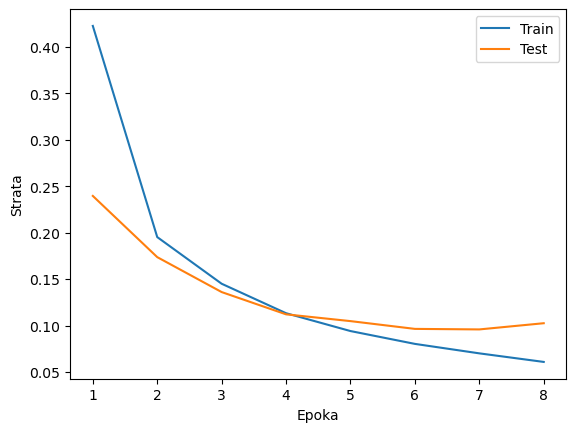

In [29]:
plt.plot(range(1, EPOCHS + 1), results["train_loss"], label = "Train")
plt.plot(range(1, EPOCHS + 1), results["test_loss"], label = "Test ")
plt.legend()
plt.ylabel("Strata")
plt.xlabel("Epoka")

In [31]:
### Evaluation - NN ACCURACY

acc_train = get_accuracy(
    model = model,
    dataset = train_dataset
)

acc_test = get_accuracy(
    model = model,
    dataset = test_dataset
)

print(f"Training data accuracy: {acc_train:.2f}")
print(f"Testing data accuracy: {acc_test:.2f}")


Training data accuracy: 0.98
Testing data accuracy: 0.97


Text(0.5, 1.0, 'Prediction: 5')

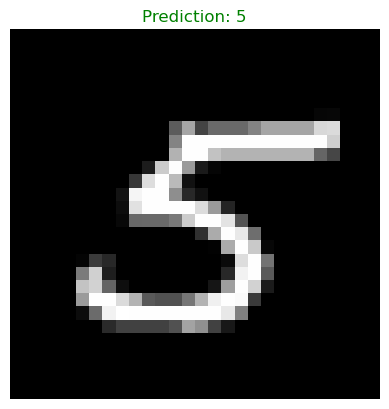

In [33]:
### Checking results by viewing a photo

RANDOM_IDX = np.random.randint(0, len(test_dataset))

# Get image and label
image, label = test_dataset[RANDOM_IDX]
image.unsqueeze(dim = 0)

# Forward Pass
model.eval()
with torch.inference_mode():
    y_logits = model(image)

# Prediction (if the prediction is correct the color is green, incorrect = red)
prediction = torch.argmax(y_logits, dim = -1).item()

plt.imshow(image.squeeze().numpy(), cmap = "gray")
plt.axis(False)
if prediction == label:
    color = "green"
else:
    color = "red"
plt.title(f"Prediction: {prediction}", color = color)